In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, ExtraTreesRegressor, BaggingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data Cleaning and Preprocessing

In [142]:
dataset = pd.read_csv("Data/raw_data.csv")
dataset.head()

,Date,Average Temperature,Maximum temperature,Minimum temperature,Atmospheric pressure at sea level,Average relative humidity,Total rainfall and / or snowmelt,Average visibility,Average wind speed,Maximum sustained wind speed,Maximum speed of wind,Rain,Snow,Thunderstorm,Fog,PM2.5 AQI Value,AQI Category
0,1/1/01,-16.9,-3.9,-20.6,1007.6,84,0.25,16.1,1.1,9.4,-,NaN,o,NaN,NaN,79.0,Moderate
1,2/1/01,-16.6,-14,-20,1008.3,82,2.03,16.1,1.7,7.6,-,NaN,o,NaN,o,NaN,NaN
2,3/1/01,-15,-12,-21,996.1,75,0.76,14.3,11.1,24.1,33.5,NaN,o,NaN,NaN,NaN,NaN
3,4/1/01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,NaN,NaN,59.0,Moderate
4,5/1/01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,NaN,NaN,NaN,NaN


In [143]:
dataset.isna().sum()

Date                                    0
Average Temperature                  3632
Maximum temperature                  3632
Minimum temperature                  3632
Atmospheric pressure at sea level    3632
Average relative humidity            3632
Total rainfall and / or snowmelt     3632
Average visibility                   3632
Average wind speed                   3632
Maximum sustained wind speed         3632
Maximum speed of wind                3857
Rain                                 5758
Snow                                 5577
Thunderstorm                         7254
Fog                                  6777
PM2.5 AQI Value                      1679
AQI Category                         1679
dtype: int64

In [147]:
# Remove data points with missing values since a lot of features have missing values
dataset.dropna(subset = ["Average Temperature"], inplace=True)
dataset.dropna(subset = ["PM2.5 AQI Value"], inplace=True)
len(dataset)

3080

In [149]:
dataset = dataset.drop(["Date","Rain","Snow","Thunderstorm","Fog","Maximum speed of wind"],axis=1)
dataset.head()

In [150]:
dataset.to_csv('Cleaned_data.csv')

In [13]:
# Remove the categorical PM AQI field for regression analysis
dataset_regression = dataset.drop(["AQI Category"],axis=1)
dataset_regression.head()

,Average Temperature,Maximum temperature,Minimum temperature,Atmospheric pressure at sea level,Average relative humidity,Total rainfall and / or snowmelt,Average visibility,Average wind speed,Maximum sustained wind speed,PM2.5 AQI Value
0,-16.9,-3.9,-20.6,1007.6,84,0.25,16.1,1.1,9.4,79.0
6,-11.2,-4,-16,983.1,75,0,16.1,12.2,22.2,66.0
12,-16.1,-11.7,-20,998.8,86,0,16.1,0.6,9.4,93.0
18,-0.2,3,-3,985.5,67,0,16.1,6.9,14.8,51.0
24,-7.9,-6,-9.4,1007.9,81,0,16.1,3.1,11.1,80.0


In [14]:
# Remove the continuous PM2.5 AQI Value field for classification analysis
dataset_clf = dataset.drop(["PM2.5 AQI Value"],axis=1)
dataset_clf.head()

,Average Temperature,Maximum temperature,Minimum temperature,Atmospheric pressure at sea level,Average relative humidity,Total rainfall and / or snowmelt,Average visibility,Average wind speed,Maximum sustained wind speed,AQI Category
0,-16.9,-3.9,-20.6,1007.6,84,0.25,16.1,1.1,9.4,Moderate
6,-11.2,-4,-16,983.1,75,0,16.1,12.2,22.2,Moderate
12,-16.1,-11.7,-20,998.8,86,0,16.1,0.6,9.4,Moderate
18,-0.2,3,-3,985.5,67,0,16.1,6.9,14.8,Moderate
24,-7.9,-6,-9.4,1007.9,81,0,16.1,3.1,11.1,Moderate


In [18]:
# Convert all string values to float since the all the features are float variables
def str_to_float(x):

    if "-" in x:

        num = x.split("-")[1]
        if num == "":
            num = 0.0
        else:
            num = -float(num)
    else:
        if x == "":
            num = 0.0
        else:
            num = float(x)
        
    return num

In [19]:
# Reduce the number of categories of PM AQI Category field to just two categories, 0:Healthy, 1:Unhealthy
def convert_to_categorical(x):
    if x in ['Moderate','Good']:
        return 0
    else:
        return 1

In [22]:
# Clean the data by converting data types of features from string to float
X = dataset_regression.iloc[:,:-1].applymap(str_to_float)

,Average Temperature,Atmospheric pressure at sea level,Average relative humidity,Total rainfall and / or snowmelt,Average visibility,Average wind speed
0,-16.9,1007.6,84.0,0.25,16.1,1.1
6,-11.2,983.1,75.0,0.00,16.1,12.2
12,-16.1,998.8,86.0,0.00,16.1,0.6
18,-0.2,985.5,67.0,0.00,16.1,6.9
24,-7.9,1007.9,81.0,0.00,16.1,3.1


In [ ]:
# Target variable for Regression
Y_regression = dataset_regression.iloc[:,-1]

# Target variable for Classification
Y_clf = dataset_clf.iloc[:,-1].apply(convert_to_categorical)

# Feature Engineering

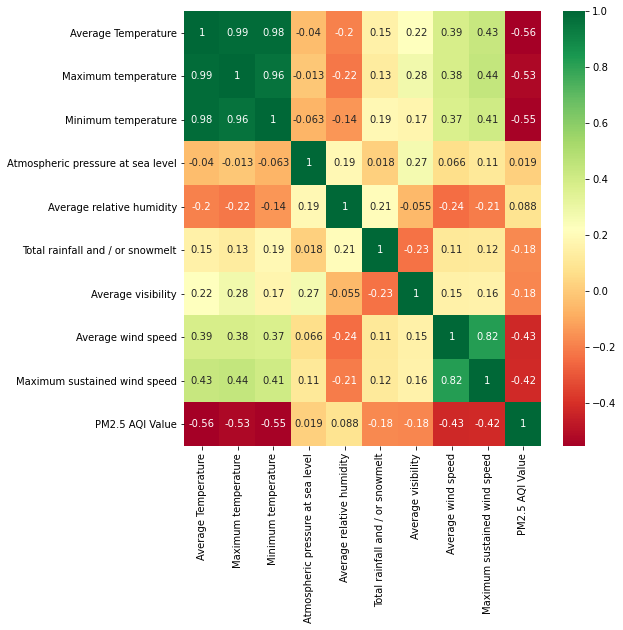

In [55]:
# Understand correlation between features and target variable
df_eda_reg = pd.concat([X,Y_regression],axis=1)
corrmat = df_eda_reg.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(8,8))
#plot heat map
g=sns.heatmap(df_eda_reg[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [56]:
# Drop the features that have high correlation with other features
X_after_fe = X_regression.drop(['Maximum temperature','Minimum temperature','Maximum sustained wind speed'],axis=1)
# X_fe = X
X_after_fe.head()

,Average Temperature,Atmospheric pressure at sea level,Average relative humidity,Total rainfall and / or snowmelt,Average visibility,Average wind speed
0,-16.9,1007.6,84.0,0.25,16.1,1.1
6,-11.2,983.1,75.0,0.00,16.1,12.2
12,-16.1,998.8,86.0,0.00,16.1,0.6
18,-0.2,985.5,67.0,0.00,16.1,6.9
24,-7.9,1007.9,81.0,0.00,16.1,3.1


# Exploratory Data Analysis

[]

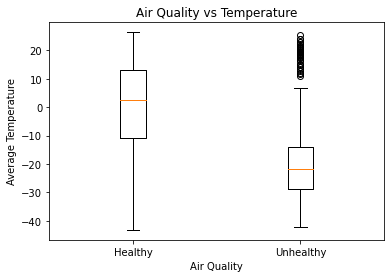

In [72]:
df_eda = pd.concat([X_after_fe,Y_clf],axis=1)
df_eda_0 = df_eda[df_eda["AQI Category"] == 0]
df_eda_1 = df_eda[df_eda["AQI Category"] == 1]

avg_temp = []
avg_temp.append(list(df_eda_0['Average Temperature']))
avg_temp.append(list(df_eda_1['Average Temperature']))
plt.boxplot(avg_temp, positions = [0,1], labels=["Healthy","Unhealthy"])
plt.xlabel("Air Quality")
plt.ylabel("Average Temperature")
plt.title("Air Quality vs Temperature")
plt.plot()

[]

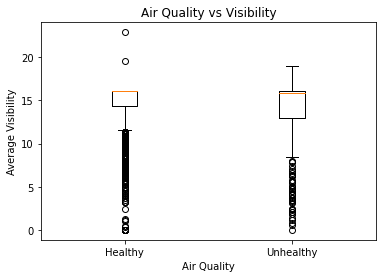

In [73]:
avg_visibility = []
avg_visibility.append(list(df_eda_0['Average visibility']))
avg_visibility.append(list(df_eda_1['Average visibility']))
plt.boxplot(avg_visibility, positions = [0,1], labels=["Healthy","Unhealthy"])
plt.xlabel("Air Quality")
plt.ylabel("Average Visibility")
plt.title("Air Quality vs Visibility")
plt.plot()

[]

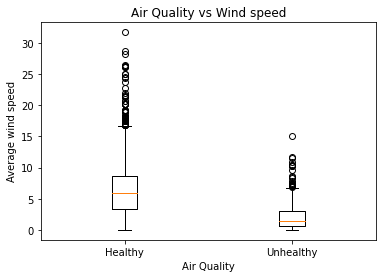

In [74]:
avg_wind = []
avg_wind.append(list(df_eda_0['Average wind speed']))
avg_wind.append(list(df_eda_1['Average wind speed']))
plt.boxplot(avg_wind, positions = [0,1], labels=["Healthy","Unhealthy"])
plt.xlabel("Air Quality")
plt.ylabel("Average wind speed")
plt.title("Air Quality vs Wind speed")
# plt.legend([{0:"Healthy"},{1:"Unhealthy"}], loc = 'best')
plt.plot()

[]

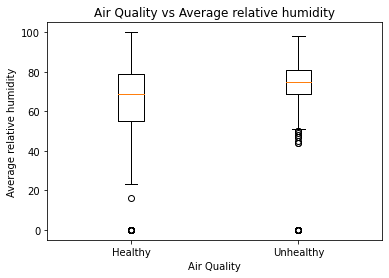

In [75]:
humidity = []
humidity.append(list(df_eda_0['Average relative humidity']))
humidity.append(list(df_eda_1['Average relative humidity']))
plt.boxplot(humidity, positions = [0,1], labels=["Healthy","Unhealthy"])
plt.xlabel("Air Quality")
plt.ylabel("Average relative humidity")
plt.title("Air Quality vs Average relative humidity")
# plt.legend([{0:"Healthy"},{1:"Unhealthy"}], loc = 'best')
plt.plot()

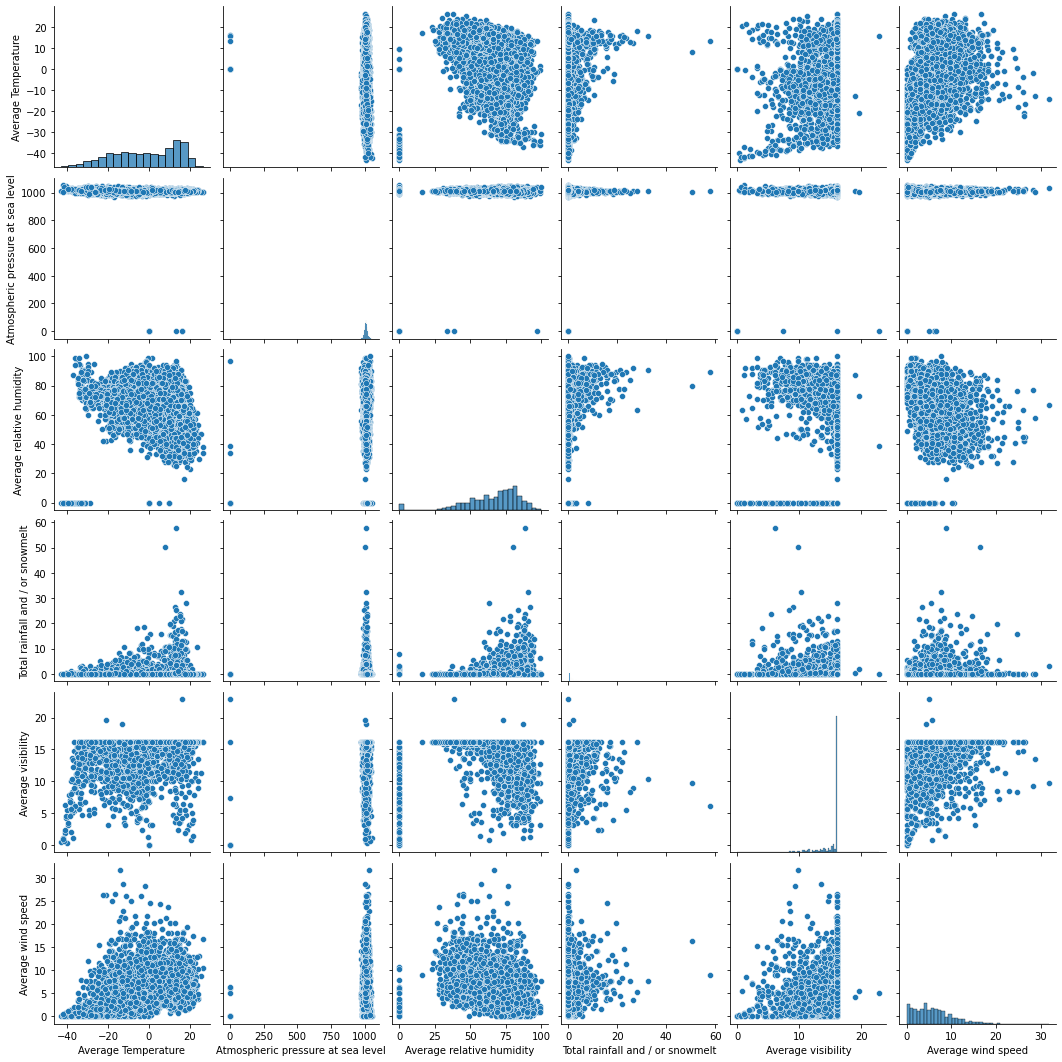

In [76]:
sns.pairplot(X_after_fe)

# Modeling

In [58]:
# Regression test train split
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(X_after_fe,Y_regression,test_size=0.3)

# Classification test train split
X_train_clf, X_test_clf, Y_train_clf, Y_test_clf = train_test_split(X_after_fe,Y_clf,test_size=0.3)

In [127]:
# Generic Model for classification and regression algorithms using GridSearchCV
def models(model, parameters, X_train, Y_train, X_test, Y_test, model_type):
    gridcv = GridSearchCV(model, parameters)
    gridcv.fit(X_train, Y_train)
    Y_pred = gridcv.predict(X_test)
    if model_type == 'classification':
        
        return gridcv.best_params_, accuracy_score(Y_pred, Y_test)
    else:
        rmse = np.sqrt(mean_squared_error(Y_pred, Y_test))
        return gridcv.best_params_, rmse

## Regression
### Linear Regression

In [105]:
lr = LinearRegression()
lr.fit(X_train_reg,Y_train_reg)
Y_pred_lr = lr.predict(X_test_reg)
rmse_lr = np.sqrt(mean_squared_error(Y_test_reg, Y_pred_lr))
print("Least RMSE for Linear Regression: ",rmse_lr)

Least RMSE for Linear Regression:  40.61123438613977


### Decision Tree Regressor

In [119]:
dtr = DecisionTreeRegressor()
dtr_parameters = {'max_depth':[None,1,2,3,4,5]}
best_parameters_dtr, rmse_dtr = models(model = dtr, parameters = dtr_parameters, X_train = X_train_reg, 
       Y_train = Y_train_reg, X_test = X_test_reg, Y_test = Y_test_reg, model_type = 'Regression')
print("Best parameter values for Decision Tree Regression:",best_parameters_dtr)
print("Least RMSE for Decision Tree Regression: ",rmse_dtr)

Best parameter values for Decision Tree Regression: {'max_depth': 5}
Least RMSE for Decision Tree Regression:  30.754182694789932


### Extra Trees Regressor

In [122]:
etr = ExtraTreesRegressor()
etr_parameters = {'n_estimators':[10,50,100,150,200], 'max_depth':[None,1,2,3,4,5]}
best_parameters_etr, rmse_etr = models(model = etr, parameters = etr_parameters, X_train = X_train_reg, 
       Y_train = Y_train_reg, X_test = X_test_reg, Y_test = Y_test_reg, model_type = 'Regression')
print("Best parameter values for Extra Trees Regression:",best_parameters_etr)
print("Least RMSE for Extra Trees Regression: ",rmse_etr)

Best parameter values for Extra Trees Regression: {'max_depth': None, 'n_estimators': 200}
Least RMSE for Extra Trees Regression:  26.676809939630992


### Lasso Regressor

In [123]:
lasso_reg = Lasso()
lasso_parameters = {'alpha':[0.001,0.01,0.1,1,10]}
best_parameters_lasso, rmse_lasso = models(model = lasso_reg, parameters = lasso_parameters, X_train = X_train_reg, 
       Y_train = Y_train_reg, X_test = X_test_reg, Y_test = Y_test_reg, model_type = 'Regression')
print("Best parameter values for Lasso Regression:",best_parameters_lasso)
print("Least RMSE for Lasso Regression: ",rmse_lasso)

Best parameter values for Lasso Regression: {'alpha': 1}
Least RMSE for Lasso Regression:  40.70127862014556


### Ridge Regressor

In [124]:
ridge_reg = Ridge()
ridge_parameters = {'alpha':[0.001,0.01,0.1,1,10]}
best_parameters_ridge, rmse_ridge = models(model = ridge_reg, parameters = ridge_parameters, X_train = X_train_reg, 
       Y_train = Y_train_reg, X_test = X_test_reg, Y_test = Y_test_reg, model_type = 'Regression')
print("Best parameter values for Ridge Regression:",best_parameters_ridge)
print("Least RMSE for Ridge Regression: ",rmse_lasso)


Best parameter values for Ridge Regression: {'alpha': 10}
Least RMSE for Ridge Regression:  40.70127862014556


## Feature importance

In [61]:
etr.feature_importances_

array([0.459135  , 0.06861599, 0.10558244, 0.03817903, 0.19267562,
       0.13581193])

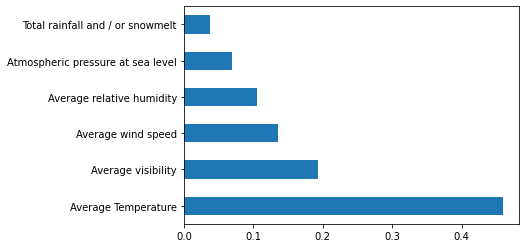

In [63]:
feature_importances = pd.Series(etr.feature_importances_, index = X_after_fe.columns)
feature_importances.nlargest(11).plot(kind='barh')
plt.show()

## Classification 

### Decision Tree Classifier

In [134]:
dtc = DecisionTreeClassifier()
dtc_parameters = {'max_features':[0.2,0.5,0.8,1], 'max_depth':[None,1,2,3,4,5,6,7,8,9,10]}
best_parameters_dtc, accuracy_dtc = models(model = dtc, parameters = dtc_parameters, X_train = X_train_clf, 
       Y_train = Y_train_clf, X_test = X_test_clf, Y_test = Y_test_clf, model_type = 'classification')
print("Best parameter values for Decision Tree Classifier:",best_parameters_dtc)
print("Best accuracy for Decision Tree Classifier: ",accuracy_dtc)


Best parameter values for Decision Tree Classifier: {'max_depth': 5, 'max_features': 0.8}
Best accuracy for Decision Tree Classifier:  0.9036796536796536


### Extra Trees Classifier

In [135]:
etc = ExtraTreesClassifier()
etc_parameters = {'n_estimators':[10,50,100,150,200], 'max_depth':[None,1,2,3,4,5,6,7,8,9,10]}
best_parameters_etc, accuracy_etc = models(model = etc, parameters = etc_parameters, X_train = X_train_clf, 
       Y_train = Y_train_clf, X_test = X_test_clf, Y_test = Y_test_clf, model_type = 'classification')
print("Best parameter values for Extra Trees Classifier:",best_parameters_etc)
print("Best accuracy for Extra Trees Classifier: ",accuracy_etc)


Best parameter values for Extra Trees Classifier: {'max_depth': None, 'n_estimators': 150}
Best accuracy for Extra Trees Classifier:  0.9199134199134199


### Random Forest Classifier

In [136]:
rfc = RandomForestClassifier()
rfc_parameters = {'n_estimators':[10,50,100,150,200], 'max_depth':[None,1,2,3,4,5,6,7,8,9,10]}
best_parameters_rfc, accuracy_rfc = models(model = rfc, parameters = rfc_parameters, X_train = X_train_clf, 
       Y_train = Y_train_clf, X_test = X_test_clf, Y_test = Y_test_clf, model_type = 'classification')
print("Best parameter values for Random Forest Classifier:",best_parameters_rfc)
print("Best accuracy for Random Forest Classifier: ",accuracy_rfc)


Best parameter values for Random Forest Classifier: {'max_depth': 6, 'n_estimators': 100}
Best accuracy for Random Forest Classifier:  0.9199134199134199


### Adaboost Classifier

In [137]:
adb = AdaBoostClassifier()
adb_parameters = {'n_estimators':[10,20,30,40,50], 'learning_rate':[0.001,0.01,0.1,1,10]}
best_parameters_adb, accuracy_adb = models(model = adb, parameters = adb_parameters, X_train = X_train_clf, 
       Y_train = Y_train_clf, X_test = X_test_clf, Y_test = Y_test_clf, model_type = 'classification')
print("Best parameter values for Adaboost Classifier:",best_parameters_adb)
print("Best accuracy for Adaboost Classifier: ",accuracy_adb)


Best parameter values for Adaboost Classifier: {'learning_rate': 1, 'n_estimators': 50}
Best accuracy for Adaboost Classifier:  0.8885281385281385


### Bagging Classifier

In [139]:
bg_clf = BaggingClassifier()
bg_parameters = {'n_estimators':[10,20,30,40,50], 'max_features':[0.5,0.6,0.7,0.8,0.9,1.0],
             'max_samples':[0.5,0.6,0.7,0.8,0.9,1.0]}
best_parameters_bg, accuracy_bg = models(model = bg_clf, parameters = bg_parameters, X_train = X_train_clf, 
       Y_train = Y_train_clf, X_test = X_test_clf, Y_test = Y_test_clf, model_type = 'classification')
print("Best parameter values for Bagging Classifier:",best_parameters_bg)
print("Best accuracy for Bagging Classifier: ",accuracy_bg)

Best parameter values for Bagging Classifier: {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50}
Best accuracy for Bagging Classifier:  0.9145021645021645
